### Riferimenti bibliografici:

* Hyvarinen, A. &  Oja E. (2012), [Independent Component Analysis: Algorithms and Applications](https://www.cs.helsinki.fi/u/ahyvarin/papers/NN00new.pdf).

# Analisi delle componenti indipendenti (ICA)

## Indice

1. [Problema del cocktail party](#cocktail)<br />
    1.1 [Simulare i dati](#simulare)<br />
    1.2 [Utilizzare ICA per ottenere i segnali originali](#ica)<br />
2. [Statlog (Landsat Satellite) Data Set](#landsat)<br />
    2.1 [Descrizione e lettura del data set](#descrizione)<br />
    2.2 [Analisi esplorativa](#esplorativa)<br />
3. [PCA, ICA e t-SNE a confronto](#confronto)<br />
4. [Ridurre la dimensionalità come parte di una pipeline di classificazione](#pipeline)<br />
    4.1 [Creare una baseline](#baseline)<br />
    4.2 [Scegliere in numero di componenti principali](#scegliere_principali)<br />
    4.3 [Scegliere in numero di componenti indipendenti](#scegliere_indipendenti)<br />

In [1]:
from sklearn.decomposition import FastICA
from sklearn.pipeline import Pipeline
import inspect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

# 1. Problema del cocktail party <a id=cocktail> </a>

## 1.1 Simulare i dati <a id=simulare> </a>

In [2]:
from msbd.datasets import CocktailParty

print(inspect.getsource(CocktailParty))

class CocktailParty:
    """Problema del cocktail party"""

    def __init__(self, A):
        self.A = A

    def s1(self, t):
        return 2 * np.sin(math.pi * t / 7)

    def s2(self, t):
        return 1 / 5 * (t % (5 * 4 + 1)) - 2

    def x1(self, t):
        return self.A[0, 0] * self.s1(t) + self.A[0, 1] * self.s2(t)

    def x2(self, t):
        return self.A[1, 0] * self.s1(t) + self.A[1, 1] * self.s2(t)



In [3]:
A = np.array(
    [[0.5, 0.5], 
     [0.2, 0.8]]
)

cp = CocktailParty(A)

In [4]:
t = np.linspace(0, 100, 1000)
S = np.c_[cp.s1(t), cp.s2(t)]
X = np.c_[cp.x1(t), cp.x2(t)]

print("Dimensioni di S: {} X {}".format(*S.shape))
print("Dimensioni di X: {} X {}".format(*X.shape))

Dimensioni di S: 1000 X 2
Dimensioni di X: 1000 X 2


In [5]:
from msbd.grafici import grafico_cocktail_party

print(inspect.getsource(grafico_cocktail_party))

def grafico_cocktail_party(t, S, X, S_hat=None):
    """Grafico del problema del cocktail party"""
    plt.suptitle("Problema del cocktail party")

    plt.subplot(411 + 200 * (S_hat is not None))
    plt.plot(t, S[:, 0])
    plt.ylabel("$s_1(t)$")

    plt.subplot(412 + 200 * (S_hat is not None))
    plt.plot(t, S[:, 1])
    plt.ylabel("$s_2(t)$")

    plt.subplot(413 + 200 * (S_hat is not None))
    plt.plot(t, X[:, 0], color="tab:orange")
    plt.ylabel("$x_1(t)$")

    plt.subplot(414 + 200 * (S_hat is not None))
    plt.plot(t, X[:, 1], color="tab:orange")
    plt.ylabel("$x_2(t)$")

    if S_hat is not None:
        plt.subplot(615)
        plt.plot(t, S_hat[:, 0], color="tab:green")
        plt.ylabel("$\hat{s}_1(t)$")

        plt.subplot(616)
        plt.plot(t, S_hat[:, 1], color="tab:green")
        plt.ylabel("$\hat{s}_2(t)$")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)



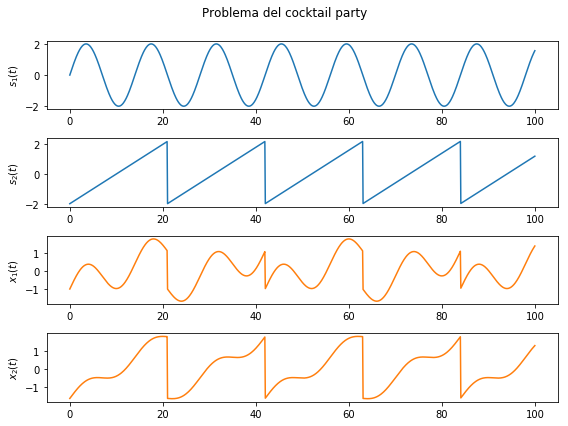

In [6]:
plt.figure(figsize=(8, 6))

grafico_cocktail_party(t, S, X)

plt.show()

## 1.2 Utilizzare ICA per ottenere i segnali originali <a id=ica> </a>

In [7]:
ica = FastICA(whiten=True, random_state=42)

S_hat = ica.fit_transform(X)

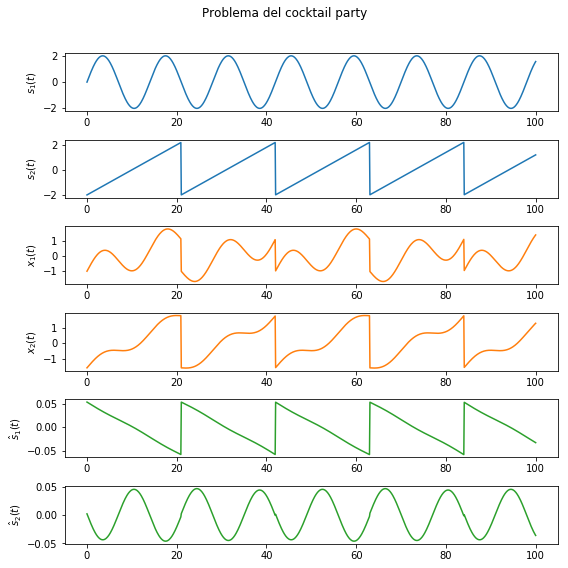

In [8]:
plt.figure(figsize=(8, 8))

grafico_cocktail_party(t, S, X, S_hat)

plt.show()

### Esercizio

Elencare tutte le differenze tra segnali veri e stimati.

In [9]:
from msbd.preprocessamento import Sbiancare


print(inspect.getsource(Sbiancare))

class Sbiancare(TransformerMixin):
    """Trasforma i dati rendendoli a media zero e varianza unitaria"""

    def __init(self):
        pass

    def fit(self, X, y=None):
        self.media_ = X.mean(axis=0)
        sigma = np.cov(X.T)

        # decomposizione in autovettori (EVD)
        self.d_, self.E_ = np.linalg.eig(sigma)

        return self

    def transform(self, X):
        check_is_fitted(self, ["media_", "d_", "E_"])

        X -= self.media_

        return X.dot(self.E_).dot(np.diag(1 / np.sqrt(self.d_))).dot(self.E_.T)

    def inverse_transform(self, X):
        check_is_fitted(self, ["media_", "d_", "E_"])

        # TODO: applicare a X la trasformazione inversa
        # ============== YOUR CODE HERE ==============
        raise NotImplementedError
        # ============================================

        return X



### Esercizio

1. Completare il metodo `inverse_transform()` della classe `Sbiancare` definita in `msbd/preprocessamento/sbiancare.py`;
2. Verificare il corretto funzionamento del metodo appena definito.

> Suggerimento: usare il fatto che la matrice $\mathbf{E}$ è una matrice [unitaria](https://it.wikipedia.org/wiki/Matrice_unitaria).

### Esercizio

1. Definire una pipeline `ica_pipe` con al primo step `Sbiancare()` e al secondo step `FastICA(whiten=False)`;
2. Ottenere `S_hat`come `S_hat = ica_pipe.fit_transform(X)`;
3. Fare nuovamente il grafico *cocktail party* utilizzando la stima di $\mathbf{S}$ ottenuta al passo precedente;
4. Commentare i risultati.

# 2. [Statlog (Landsat Satellite) Data Set](https://archive.ics.uci.edu/ml/datasets/Statlog+(Landsat+Satellite)) <a id=landsat> </a>

## 2.1 Descrizione e lettura del data set <a id=descrizione> </a>

### Data Set Information:

The database consists of the multi-spectral values of pixels in 3x3 neighbourhoods in a satellite image, and the classification associated with the central pixel in each neighbourhood. The aim is to predict this classification, given the multi-spectral values. In the sample database, the class of a pixel is coded as a number. 

The Landsat satellite data is one of the many sources of information available for a scene. The interpretation of a scene by integrating spatial data of diverse types and resolutions including multispectral and radar data, maps indicating topography, land use etc. is expected to assume significant importance with the onset of an era characterised by integrative approaches to remote sensing (for example, NASA's Earth Observing System commencing this decade). Existing statistical methods are ill-equipped for handling such diverse data types. Note that this is not true for Landsat MSS data considered in isolation (as in this sample database). This data satisfies the important requirements of being numerical and at a single resolution, and standard maximum-likelihood classification performs very well. Consequently, for this data, it should be interesting to compare the performance of other methods against the statistical approach. 

One frame of Landsat MSS imagery consists of four digital images of the same scene in different spectral bands. Two of these are in the visible region (corresponding approximately to green and red regions of the visible spectrum) and two are in the (near) infra-red. Each pixel is a 8-bit binary word, with 0 corresponding to black and 255 to white. The spatial resolution of a pixel is about 80m x 80m. Each image contains 2340 x 3380 such pixels. 

The database is a (tiny) sub-area of a scene, consisting of 82 x 100 pixels. Each line of data corresponds to a 3x3 square neighbourhood of pixels completely contained within the 82x100 sub-area. Each line contains the pixel values in the four spectral bands (converted to ASCII) of each of the 9 pixels in the 3x3 neighbourhood and a number indicating the classification label of the central pixel. The number is a code for the following classes: 

#### Number: Class
* 1:  red soil 
* 2:  cotton crop 
* 3:  grey soil 
* 4:  damp grey soil 
* 5:  soil with vegetation stubble 
* 6:  mixture class (all types present) 
* 7:  very damp grey soil 

NB. There are no examples with class 6 in this dataset. 

The data is given in random order and certain lines of data have been removed so you cannot reconstruct the original image from this dataset. 

In each line of data the four spectral values for the top-left pixel are given first followed by the four spectral values for the top-middle pixel and then those for the top-right pixel, and so on with the pixels read out in sequence left-to-right and top-to-bottom. Thus, the four spectral values for the central pixel are given by attributes 17,18,19 and 20. If you like you can use only these four attributes, while ignoring the others. This avoids the problem which arises when a 3x3 neighbourhood straddles a boundary. 


### Attribute Information:

The attributes are numerical, in the range 0 to 255.

In [10]:
CANALI = ["R", "G", "B", "A"]
CLASSI = [
    "red soil", 
    "cotton crop", 
    "grey soil", 
    "damp grey soil", 
    "soil with vegetation stubble",
    "very damp grey soil",
]
NUMERO_CLASSE = dict(zip([1, 2, 3, 4, 5, 7], CLASSI))
NOMI = ["Pixel{}_{}".format(i, c) for i in range(9) for c in CANALI] + ["Classe"]

URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/satimage/sat.trn"

dati = pd.read_table(URL, sep=" ", names=NOMI)
print("Dimensioni: {} X {}".format(*dati.shape))
dati.head(2)

Dimensioni: 4435 X 37


,Pixel0_R,Pixel0_G,Pixel0_B,Pixel0_A,Pixel1_R,Pixel1_G,Pixel1_B,Pixel1_A,Pixel2_R,Pixel2_G,...,Pixel6_A,Pixel7_R,Pixel7_G,Pixel7_B,Pixel7_A,Pixel8_R,Pixel8_G,Pixel8_B,Pixel8_A,Classe
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,3


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(dati.iloc[:, :-1], dati.iloc[:, -1], 
                                                  test_size=0.25, random_state=42)

## 2.2 Analisi esplorativa <a id=esplorativa> </a>

In [12]:
dati.iloc[:, :-1].describe()

,Pixel0_R,Pixel0_G,Pixel0_B,Pixel0_A,Pixel1_R,Pixel1_G,Pixel1_B,Pixel1_A,Pixel2_R,Pixel2_G,...,Pixel6_B,Pixel6_A,Pixel7_R,Pixel7_G,Pixel7_B,Pixel7_A,Pixel8_R,Pixel8_G,Pixel8_B,Pixel8_A
count,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,...,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000
mean,69.473957,83.855242,99.322886,82.555581,69.208794,83.499436,99.174521,82.480496,68.963472,83.131003,...,99.324690,82.673957,69.033145,83.434273,99.183766,82.638106,68.797069,83.153326,99.061556,82.584442
std,13.649635,22.725079,16.672166,18.695450,13.552423,22.811809,16.627583,18.714272,13.497858,22.813312,...,16.701527,18.884322,13.533934,22.812090,16.741240,18.939820,13.437785,22.762684,16.660735,18.895513
min,40.000000,27.000000,56.000000,33.000000,40.000000,27.000000,50.000000,29.000000,40.000000,27.000000,...,53.000000,34.000000,39.000000,27.000000,50.000000,29.000000,40.000000,27.000000,50.000000,29.000000
25%,60.000000,71.000000,85.000000,70.000000,60.000000,71.000000,85.000000,69.000000,60.000000,71.000000,...,85.000000,70.000000,60.000000,71.000000,85.000000,69.000000,60.000000,71.000000,85.000000,69.000000
50%,68.000000,87.000000,101.000000,83.000000,68.000000,85.000000,101.000000,81.000000,67.000000,85.000000,...,101.000000,81.000000,68.000000,85.000000,101.000000,81.000000,67.000000,85.000000,100.000000,81.000000
75%,80.000000,103.000000,113.000000,92.000000,80.000000,103.000000,113.000000,92.000000,79.000000,103.000000,...,113.000000,92.000000,79.500000,103.000000,113.000000,92.000000,79.000000,103.000000,113.000000,92.000000
max,104.000000,137.000000,140.000000,154.000000,102.000000,137.000000,145.000000,157.000000,104.000000,130.000000,...,140.000000,154.000000,104.000000,128.000000,145.000000,157.000000,104.000000,130.000000,145.000000,157.000000


In [13]:
y_train.replace(NUMERO_CLASSE).value_counts()

red soil                        793
very damp grey soil             778
grey soil                       733
cotton crop                     361
soil with vegetation stubble    336
damp grey soil                  325
Name: Classe, dtype: int64

In [14]:
from msbd.grafici import grafico_immagine_satellitare

print(inspect.getsource(grafico_immagine_satellitare))

def grafico_immagine_satellitare(X, y):
    plt.suptitle("Un'immagine per classe selezionata casualmente")

    for i, (num_cl, cl) in enumerate(NUMERO_CLASSE.items()):
        plt.subplot(231 + i)
        plt.title(cl)
        idx = np.random.choice(X.loc[y == num_cl].index)
        image = X.loc[idx].values.reshape((3, 3, 4)).astype(np.uint8)
        plt.imshow(image, interpolation='none')
        plt.xticks([0.5, 1.5], [])
        plt.yticks([0.5, 1.5], [])
        plt.grid(color='black')



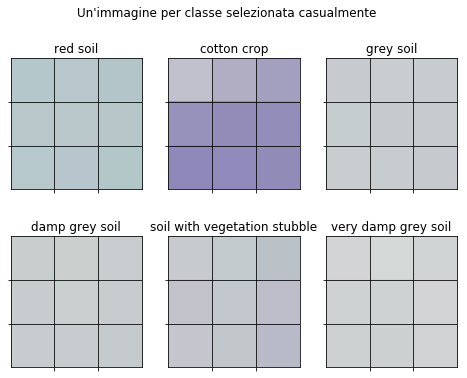

In [15]:
np.random.seed(42)

plt.figure(figsize=(8, 6))

grafico_immagine_satellitare(X_train, y_train)

plt.show()

In [16]:
from msbd.grafici import diagrammi_scatola_baffi_pixel

print(inspect.getsource(diagrammi_scatola_baffi_pixel))

def diagrammi_scatola_baffi_pixel(X, y, posizione):
    plt.suptitle("Diagramma a scatola e baffi dei pixel in posizione "
        "{} per ogni combinazione di classe e canale".format(posizione))

    for i in range(4):
        plt.subplot(221 + i)
        canale = CANALI[i]
        plt.title('Canale {}'.format(canale))
        diagrammi_scatola_baffi_classi(y,
            X["Pixel{}_{}".format(posizione, canale)])
        plt.xlabel("")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)



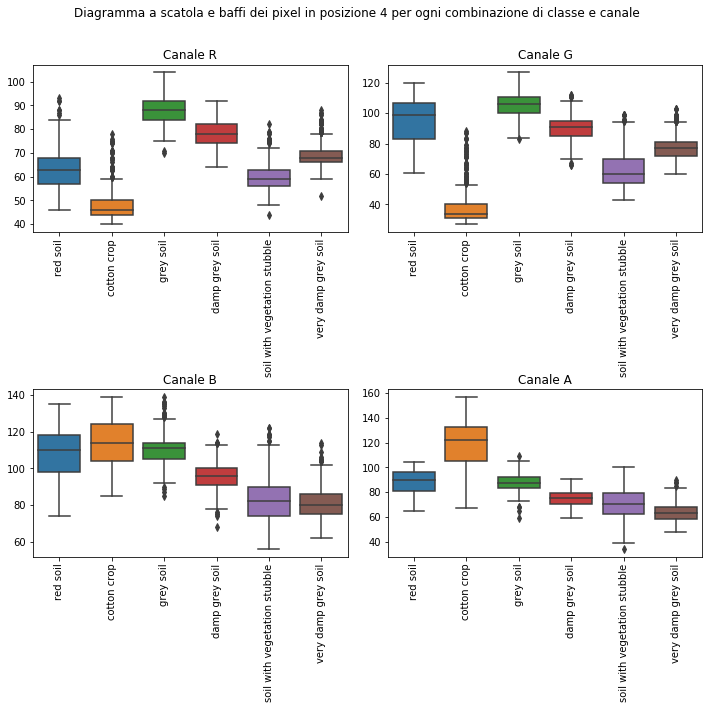

In [17]:
plt.figure(figsize=(10, 10))

diagrammi_scatola_baffi_pixel(X_train, y_train, 4)

plt.show()

In [18]:
from msbd.grafici import diagrammi_scatola_baffi_classi

print(inspect.getsource(diagrammi_scatola_baffi_classi))

def diagrammi_scatola_baffi_classi(x, y):
    sns.boxplot(x=np.asarray(x), y=np.asarray(y))
    plt.xticks(range(6), CLASSI, rotation="vertical", fontsize=10)



### Esercizio

1. Stimare le prime due componenti ICA di `X_train` e assegnarle alla variabile `X_ica`;
2. Utilizzare la funzione `diagrammi_scatola_baffi_classi` per fare i diagrammi a scatola e baffi delle classi sia per la prima che per la seconda componente ICA.

> Nota: `x=y_train` e `y=X_ica[:, 0]` per la prima componente (pensare a cosa si vuole vedere sull'asse x del grafico).

# 3. PCA, ICA e t-SNE a confronto <a id=confronto> </a>

In [19]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

np.random.seed(42)

ica = FastICA(n_components=2, whiten=True)
pca = PCA(n_components=2, whiten=True)
tsne = TSNE(n_components=2)

X_ica = ica.fit_transform(X_train)
X_pca = pca.fit_transform(X_train)
X_tsne  = tsne.fit_transform(X_train)

In [20]:
from msbd.grafici import grafico_componenti

print(inspect.getsource(grafico_componenti))

def grafico_componenti(X, y):
    for i, classe in NUMERO_CLASSE.items():
        plt.scatter(X[y == i, 0], X[y == i, 1], color=plt.cm.Set2(i),
            alpha=0.5, label=classe)
    plt.legend()
    plt.xlabel("Prima componente")
    plt.ylabel("Seconda componente")
    plt.xticks([])
    plt.yticks([])



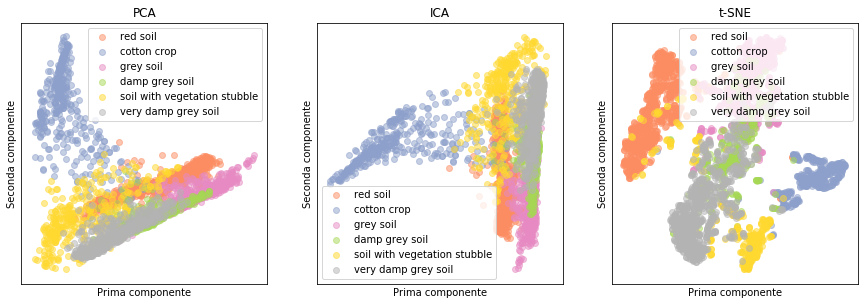

In [21]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title("PCA")
grafico_componenti(X_pca, y_train)

plt.subplot(132)
plt.title("ICA")
grafico_componenti(X_ica, y_train)

plt.subplot(133)
plt.title("t-SNE")
grafico_componenti(X_tsne, y_train)

# plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

### Esercizio

Commentare i risultati.

# 4. Ridurre la dimensionalità come parte di una pipeline di classificazione <a id=pipeline> </a>

## 4.1 Creare una baseline <a id=baseline> </a>

In [22]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  accuracy_score

In [23]:
dc = DummyClassifier(strategy="most_frequent")

dc.fit(X_train, y_train)
y_pred = dc.predict(X_val)

dc_acc = accuracy_score(y_val, y_pred)

print("Accuratezza DummyClassifier(strategy=\"most_frequent\"): {:.1f}%".format(100 * dc_acc))

Accuratezza DummyClassifier(strategy="most_frequent"): 25.2%


In [24]:
multinom = LogisticRegression(penalty="l2", multi_class="multinomial", C=float("inf"), solver="newton-cg")

multinom.fit(X_train, y_train)
y_pred = multinom.predict(X_val)

multinom_acc = accuracy_score(y_val, y_pred)

print("Accuratezza DummyClassifier(strategy=\"most_frequent\"): {:.1f}%".format(100 * dc_acc))
print("Accuratezza LogisticRegression(multi_class=\"multinomial\"): {:.1f}%".format(100 * multinom_acc))

Accuratezza DummyClassifier(strategy="most_frequent"): 25.2%
Accuratezza LogisticRegression(multi_class="multinomial"): 86.3%


/Users/mariolarcher/anaconda3/envs/msbd/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


## 4.2 Scegliere in numero di componenti principali <a id=scegliere_principali> </a>

### Scegliere in numero di componenti principali studiando la varianza spiegata

In [25]:
pca = PCA(whiten=True)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [26]:
from msbd.grafici import grafico_varianza_spiegata

print(inspect.getsource(grafico_varianza_spiegata))

def grafico_varianza_spiegata(varianza_spiegata, cumulata=False):
    titolo = "% varianza spiegata"

    if cumulata:
        titolo += " cumulata al variare del numero di componenti"
        varianza_spiegata = varianza_spiegata.cumsum()
    else:
        titolo += " da ogni componente"

    plt.title(titolo)
    plt.plot(range(1, len(varianza_spiegata) + 1), varianza_spiegata,
        marker='o', ls='--')
    plt.xlabel("Componenti")
    plt.ylabel("% varianza spiegata")
    plt.grid()



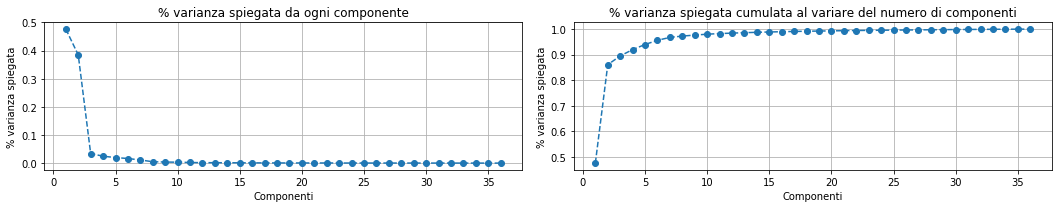

In [27]:
plt.figure(figsize=(15, 3))
plt.subplot(121)
grafico_varianza_spiegata(pca.explained_variance_ratio_)

plt.subplot(122)
grafico_varianza_spiegata(pca.explained_variance_ratio_, cumulata=True)

plt.tight_layout()
plt.show()

In [28]:
N_COMPONENTS = 3

multinom = Pipeline([
    ("pca", PCA(n_components=N_COMPONENTS, whiten=True)),
    ("multinom", LogisticRegression(penalty="l2", multi_class="multinomial", C=float("inf"), solver="newton-cg")),
])

multinom.fit(X_train, y_train)
y_pred = multinom.predict(X_val)

print("Accuratezza DummyClassifier(strategy=\"most_frequent\"): {:.1f}%".format(100 * dc_acc))
print("Accuratezza LogisticRegression(multi_class=\"multinomial\"): {:.1f}%".format(100 * multinom_acc))
print("Accuratezza PCA(n_components={}) + LogisticRegression(multi_class=\"multinomial\"): {:.1f}%".format(N_COMPONENTS, 100 * accuracy_score(y_val, y_pred)))

Accuratezza DummyClassifier(strategy="most_frequent"): 25.2%
Accuratezza LogisticRegression(multi_class="multinomial"): 86.3%
Accuratezza PCA(n_components=3) + LogisticRegression(multi_class="multinomial"): 84.5%


### Scegliere il numero di componenti principali in base all'errore sull'insieme di validation

In [29]:
multinom = Pipeline([
    ("pca", PCA(whiten=True)),
    ("multinom", LogisticRegression(penalty="l2", multi_class="multinomial", C=float("inf"), solver="newton-cg")),
])

acc = []

for n_components in range(1, 26):
    multinom.set_params(pca__n_components=n_components)
    multinom.fit(X_train, y_train)
    y_pred = multinom.predict(X_val)
    acc.append(accuracy_score(y_val, y_pred))

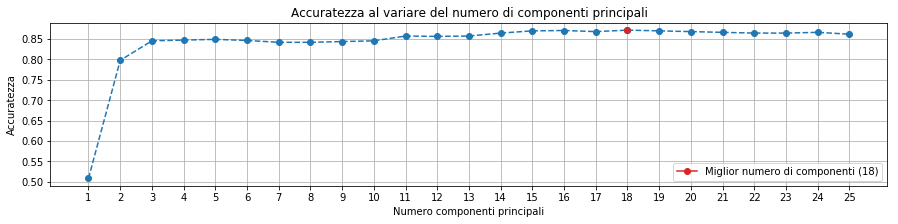

In [30]:
plt.figure(figsize=(15, 3))

plt.title("Accuratezza al variare del numero di componenti principali")
plt.plot(range(1, len(acc) + 1), acc, marker='o', ls='--')
plt.plot(np.argmax(acc) + 1, acc[np.argmax(acc)], c="tab:red", marker="o", 
         label="Miglior numero di componenti ({})".format(np.argmax(acc) + 1))
plt.xticks(range(1, len(acc) + 1), range(1, len(acc) + 1))
plt.xlabel("Numero componenti principali")
plt.ylabel("Accuratezza")
plt.legend()
plt.grid()

plt.show()

### Esercizio

Cambiare il `random_state` in `train_test_split` (nella cella dove abbiamo diviso i dati in `train` e `val`) e rieseguire le celle fino al grafico sopra. Il numero di componenti migliore è lo stesso? Commentare.

> Nota: in questo caso sarebbe stato meglio utilizzare la convalida incrociata, in modo da ottenere stime più precise e i relativi errori standard. Una volta imparata la teoria relativa, in futuro considerare l'utilizzo della funzione di scikit-learn [validation_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html#sklearn.model_selection.validation_curve).

In [31]:
N_COMPONENTS = 18

multinom = Pipeline([
    ("pca", PCA(n_components=N_COMPONENTS, whiten=True)),
    ("multinom", LogisticRegression(penalty="l2", multi_class="multinomial", C=float("inf"), solver="newton-cg")),
])

multinom.fit(X_train, y_train)
y_pred = multinom.predict(X_val)

print("Accuratezza DummyClassifier(strategy=\"most_frequent\"): {:.1f}%".format(100 * dc_acc))
print("Accuratezza LogisticRegression(multi_class=\"multinomial\"): {:.1f}%".format(100 * multinom_acc))
print("Accuratezza PCA(n_components={}) + LogisticRegression(multi_class=\"multinomial\"): {:.1f}%".format(N_COMPONENTS, 100 * accuracy_score(y_val, y_pred)))

Accuratezza DummyClassifier(strategy="most_frequent"): 25.2%
Accuratezza LogisticRegression(multi_class="multinomial"): 86.3%
Accuratezza PCA(n_components=18) + LogisticRegression(multi_class="multinomial"): 87.1%


In [32]:
from msbd.grafici import grafico_matrice_confusione

print(inspect.getsource(grafico_matrice_confusione))

def grafico_matrice_confusione(y_true, y_pred, classi,
    titolo="Matrice di confusione", cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(titolo)
    plt.colorbar(fraction=0.04, pad=0.2)
    tick_marks = range(len(classi))
    plt.xticks(tick_marks, classi, rotation=90)
    plt.yticks(tick_marks, classi)
    thresh = cm.max() / 2
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("Classe osservata")
    plt.xlabel("Classe prevista")



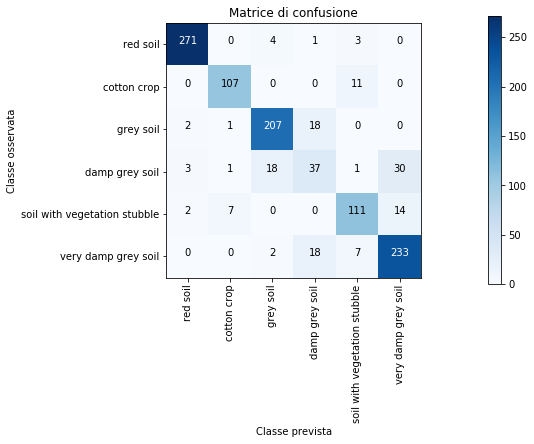

In [33]:
plt.figure(figsize=(6, 6))

grafico_matrice_confusione(y_val, y_pred, CLASSI)

plt.show()

### Esercizio

Si potrebbe calcolare l'accuratezza a partire dalla matrice di confusione? Se si, come?

## 4.3 Scegliere in numero di componenti indipendenti <a id=scegliere_indipendenti> </a>

### Esercizio

Ripetere quando visto per PCA utilizzando ICA.